## Perturbation of sequences
### Dataset: SARS-CoV-2 aligned w.r.t WIV04
### Number of sequences = 94 (93 + 1) 
### Model: VirProBERT (CoV-S-UniRef90, CoV-S-UniRef90-aligned) 

In [1]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniref90',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniref90/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniref90/../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sars-cov-2/uniref90/..']

In [2]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
cmap = sns.color_palette("vlag", as_cmap=True)

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [3]:
human_label = "Human"
pred_diff_col = f"{human_label}_pred_diff"
perturbation_processed_output_dir = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/cov-S-aligned-multi-transfer_learning_mlm_fnn_2l_lr1e-4/processed")
perturbation_output_files = os.listdir(perturbation_processed_output_dir)
len(perturbation_output_files)

94

In [4]:
perturbed_output_dfs = []
for perturbation_output_file in perturbation_output_files:
    df = pd.read_csv(os.path.join(perturbation_processed_output_dir, perturbation_output_file))
    orig_seq_df = df[df["orig_token"] == df["new_token"]]
    orig_pred_val = orig_seq_df[human_label].values[0]
    df[pred_diff_col] = df[human_label] - orig_pred_val
    df[f"abs_{pred_diff_col}"] = df[pred_diff_col].abs()
    perturbed_output_dfs.append(df)
perturbed_output_df = pd.concat(perturbed_output_dfs)

In [5]:
print(perturbed_output_df.shape)
perturbed_output_df.head()

(2978369, 15)


,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff
0,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,K,2234,Q,0.000000,0.000000
1,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,F,2233,H,0.000000,0.000000
2,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,E,2235,T,0.000000,0.000000
3,0.000213,0.004058,0.081635,0.001788,0.003794,0.005416,0.779555,0.123542,UniRef90_A0A8B1JBP8,Human,E,1787,U,0.000000,0.000000
4,0.000281,0.004669,0.079043,0.002242,0.004940,0.005237,0.771312,0.132277,UniRef90_A0A8B1JBP8,Human,F,130,M,-0.008243,0.008243


### WIV04 reference sequence

In [6]:
wiv04_aligned_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "input/data/coronaviridae/20240313/uniref/aligned/coronaviridae_s_uniref90_embl_hosts_pruned_metadata_corrected_species_virus_host_vertebrates_w_seq_t0.01_c8_aligned.csv")
wiv04_df = pd.read_csv(wiv04_aligned_file_path)
wiv04_df = wiv04_df[wiv04_df["uniref90_id"] == "WIV04"]
wiv04_df.head()

,uniref90_id,aligned_seq,seq,virus_name,virus_host_name,human_binary_label
0,WIV04,--------------MFVFLVLLPLVSS--------Q----------...,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,homo sapiens,homo sapiens


In [7]:
wiv04_aligned_seq = wiv04_df["aligned_seq"].values[0]
wiv04_aligned_seq

'--------------MFVFLVLLPLVSS--------Q----------------CVN--------LTTRTQLPPAY----TNSFTRGVYYPDKVFRSSVLHSTQDLFLPF----------------FSNVTWFHAIHVSGT---------------NGTKRFDNPVLPFN-DGVYFASTEK---------SNIIRGWIFGTTLDSKTQSLLIVNNAT---------------------------N--------------------------VVIKVCEFQ----------------------FCNDPFLG-----VYYHKNNK------------SWMESEFRVY-----------------------------------------------------------------------------SSANNC--TFEYVSQPFLM------------DLEGKQG-NFKNLREFV------------------------------------------------------------------------------------------------------------------------------------------------------------------F-----------KNID-------------GYFKIYSKHTPIN--LVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIY------QTSNFRVQPTESIVRF----------------------------------------------------PNITNLCPFGEVFNATRF-ASVY--AWNRKRI----------SNCVADY--------------------------------------SVLYN----SASFST--------------------------------FKCYGVSP-------

In [8]:
wiv04_position_mapping = {}
pos = 0
for i, token in enumerate(wiv04_aligned_seq):
    if token == "-":
        continue
    else:
        pos += 1
        wiv04_position_mapping[i] = pos
        
try:
    perturbed_output_df["perturb_seq_pos"] = perturbed_output_df["perturb_pos"].apply(lambda x: int(wiv04_position_mapping[x]) if x in wiv04_position_mapping else None)
except: 
    pass

### Distribution of prediction difference values

/tmp/ipykernel_3245247/2860024834.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(perturbed_output_df["Human_pred_diff"])


<Figure size 432x288 with 0 Axes>

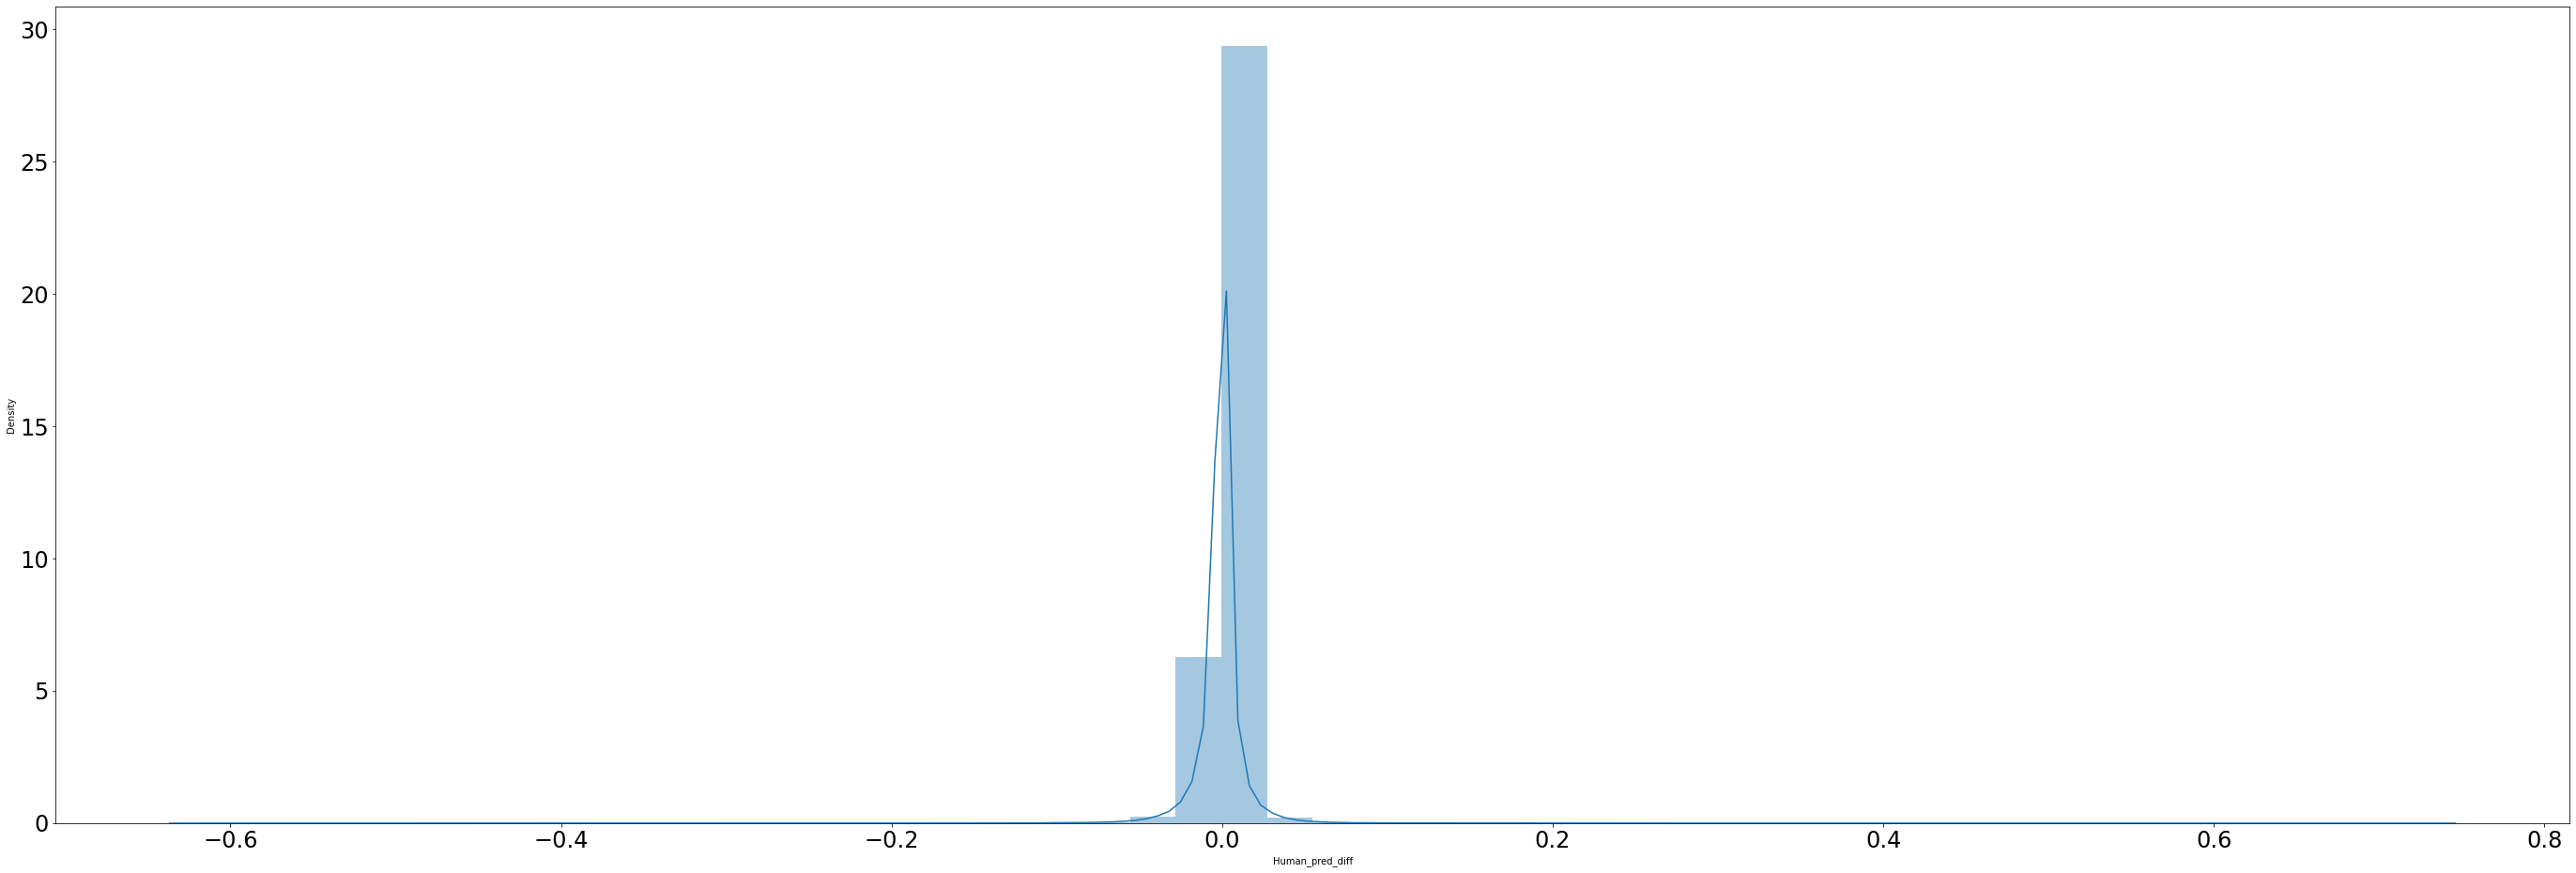

In [9]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
sns.distplot(perturbed_output_df["Human_pred_diff"])
plt.show()

In [10]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df[pred_diff_col], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})
    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.635250,-0.520263,25,0.000839
1,-0.520263,-0.405276,138,0.004633
2,-0.405276,-0.290288,261,0.008763
3,-0.290288,-0.175301,415,0.013934
4,-0.175301,-0.060314,4903,0.164620
5,-0.060314,0.054673,2968349,99.663574
6,0.054673,0.169660,3963,0.133059
7,0.169660,0.284648,230,0.007722
8,0.284648,0.399635,54,0.001813
9,0.399635,0.514622,23,0.000772


In [11]:
perturbed_output_df_selected = perturbed_output_df[perturbed_output_df[f"abs_{pred_diff_col}"] > 0.1]
print(f"Number of sequences = {perturbed_output_df_selected.shape[0]}")
print(f"Number of unique positions = {len(perturbed_output_df_selected['perturb_seq_pos'].unique())}")
print(f"Unique positions = {perturbed_output_df_selected['perturb_seq_pos'].unique()}")

Number of sequences = 3146
Number of unique positions = 135
Unique positions = [  6. 170. 190. 413. 487. 399.   7.   3. 186. 405. 188. 402. 403. 191.
 185. 482.   4. 485. 484. 401. 404.  98.   5. 400. 483. 412.  99.  22.
 406. 409. 410. 408. 411. 407. 415.  64. 486. 416. 488. 496. 248. 498.
 423.  82. 143.  88. 142. 491. 454. 493. 420. 471.  34. 145. 475. 417.
 117.  78. 110. 414.  49. 494.  84.  70. 169.  79. 489.  75.  92.  74.
 422.  54.  67. 182.  83. 141. 127.  57. 452.  81.  85. 111.  90. 419.
  69.  80. 161. 128.   2. 144. 118. 418.  48.  68.  77. 109.  91.  13.
 305.  89.  76. 108. 492. 490.  14.   9. 439. 464. 293. 457.  21.   8.
 430.  18. 237. 100.  23. 192. 236.  37.  38. 421.  nan 427. 140. 428.
 429. 383. 104.  11.  10. 176. 189. 187.   1.]


In [12]:
perturbed_output_df_selected["experiment"] = "sarscov2-uniref90-aligned-multi"
perturbation_selected_output_file_path = os.path.join(os.getcwd(), "..", "..", "..", "..", "..", "output/raw/coronaviridae_s_prot_perturbation/20240320/sars-cov-2/analysis/uniref90_aligned_multi.csv")
perturbed_output_df_selected.to_csv(perturbation_selected_output_file_path, index=False)

/tmp/ipykernel_3245247/2443498182.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["experiment"] = "sarscov2-uniref90-aligned-multi"


### Top 10 perturbations with highest change in prediction probability

In [13]:
perturbed_output_df_selected.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)


,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment
20452,0.000008,0.001149,0.036094,0.000041,0.000161,0.003146,0.953277,0.006124,WIV04,Human,E,1300,X,0.744596,0.744596,484.0,sarscov2-uniref90-aligned-multi
2469,0.000008,0.001267,0.042944,0.000045,0.000173,0.004191,0.944884,0.006487,WIV04,Human,N,1303,X,0.736203,0.736203,487.0,sarscov2-uniref90-aligned-multi
11762,0.000013,0.001175,0.060889,0.000085,0.000218,0.005932,0.920613,0.011074,WIV04,Human,G,1301,X,0.711932,0.711932,485.0,sarscov2-uniref90-aligned-multi
2347,0.000015,0.001009,0.073336,0.000112,0.000232,0.007247,0.903924,0.014124,WIV04,Human,G,1298,X,0.695243,0.695243,482.0,sarscov2-uniref90-aligned-multi
19340,0.000015,0.001094,0.074143,0.000107,0.000237,0.007343,0.903106,0.013955,WIV04,Human,V,1299,X,0.694425,0.694425,483.0,sarscov2-uniref90-aligned-multi
22149,0.090379,0.011242,0.018383,0.160734,0.047422,0.001491,0.233590,0.436759,UniRef90_A0A8B6RK62,Human,R,1075,L,-0.635250,0.635250,408.0,sarscov2-uniref90-aligned-multi
23362,0.086792,0.011347,0.018183,0.154515,0.048545,0.001473,0.239058,0.440086,UniRef90_A0A8B6RKY6,Human,R,1075,L,-0.627737,0.627737,408.0,sarscov2-uniref90-aligned-multi
21498,0.000021,0.001011,0.127156,0.000202,0.000296,0.013730,0.832663,0.024920,WIV04,Human,C,1304,X,0.623982,0.623982,488.0,sarscov2-uniref90-aligned-multi
22658,0.000021,0.001076,0.131763,0.000204,0.000341,0.015658,0.825012,0.025925,WIV04,Human,F,1302,X,0.616331,0.616331,486.0,sarscov2-uniref90-aligned-multi
16066,0.025643,0.013166,0.036098,0.072224,0.056039,0.004480,0.317291,0.475060,UniRef90_A0A8B6RBS0,Human,R,1075,L,-0.578407,0.578407,408.0,sarscov2-uniref90-aligned-multi


In [14]:
perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)
perturbed_output_df_selected.head()

/tmp/ipykernel_3245247/2825421286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  perturbed_output_df_selected["perturbation_id"] = perturbed_output_df_selected.apply(lambda x: f"{x['perturb_seq_pos']}_{x['new_token']}", axis=1)


,Cat,Chicken,Chinese rufous horseshoe bat,Ferret,Gray wolf,Horshoe bat,Human,Pig,uniref90_id,y_true,orig_token,perturb_pos,new_token,Human_pred_diff,abs_Human_pred_diff,perturb_seq_pos,experiment,perturbation_id
554,0.000401,0.002697,0.101088,0.004090,0.003362,0.006991,0.666540,0.214832,UniRef90_A0A8B1JBP8,Human,V,19,Q,-0.113015,0.113015,6.0,sarscov2-uniref90-aligned-multi,6.0_Q
960,0.000735,0.005384,0.084449,0.005814,0.008942,0.006288,0.667355,0.221033,UniRef90_A0A8B1JBP8,Human,Y,431,M,-0.112200,0.112200,170.0,sarscov2-uniref90-aligned-multi,170.0_M
1433,0.000504,0.002628,0.100687,0.005171,0.003738,0.007241,0.637660,0.242372,UniRef90_A0A8B1JBP8,Human,V,19,R,-0.141895,0.141895,6.0,sarscov2-uniref90-aligned-multi,6.0_R
1523,0.000419,0.005498,0.094154,0.003653,0.007767,0.007676,0.673636,0.207196,UniRef90_A0A8B1JBP8,Human,R,464,I,-0.105919,0.105919,190.0,sarscov2-uniref90-aligned-multi,190.0_I
3604,0.000439,0.005293,0.094644,0.003913,0.007972,0.007658,0.669647,0.210434,UniRef90_A0A8B1JBP8,Human,R,464,B,-0.109908,0.109908,190.0,sarscov2-uniref90-aligned-multi,190.0_B


In [15]:
mean_diff_df = perturbed_output_df_selected[["perturbation_id", "abs_Human_pred_diff"]].groupby("perturbation_id").mean(pred_diff_col)

In [16]:
mean_diff_df = mean_diff_df.reset_index()

In [17]:
mean_diff_df[["perturb_seq_pos", "new_token"]] = mean_diff_df["perturbation_id"].str.split("_", expand=True)

In [18]:
mean_diff_df.head()

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
0,1.0_E,0.105144,1.0,E
1,10.0_E,0.100002,10.0,E
2,100.0_W,0.103122,100.0,W
3,104.0_C,0.105376,104.0,C
4,104.0_D,0.108462,104.0,D


In [19]:
mean_diff_df[mean_diff_df[["perturb_seq_pos", "new_token"]].duplicated()]

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token


In [20]:
df = mean_diff_df.pivot(columns="perturb_seq_pos", index="new_token", values="abs_Human_pred_diff")
# df[token_positions]

In [21]:
mean_diff_df.sort_values(by="abs_Human_pred_diff", ascending=False).head(10)

,perturbation_id,abs_Human_pred_diff,perturb_seq_pos,new_token
186,408.0_L,0.427769,408.0,L
137,402.0_L,0.344687,402.0,L
158,405.0_L,0.336666,405.0,L
204,409.0_L,0.294175,409.0,L
252,483.0_H,0.266874,483.0,H
208,410.0_L,0.263494,410.0,L
249,482.0_H,0.263034,482.0,H
291,487.0_X,0.262695,487.0,X
277,484.0_X,0.255019,484.0,X
261,484.0_H,0.246628,484.0,H


<Figure size 432x288 with 0 Axes>

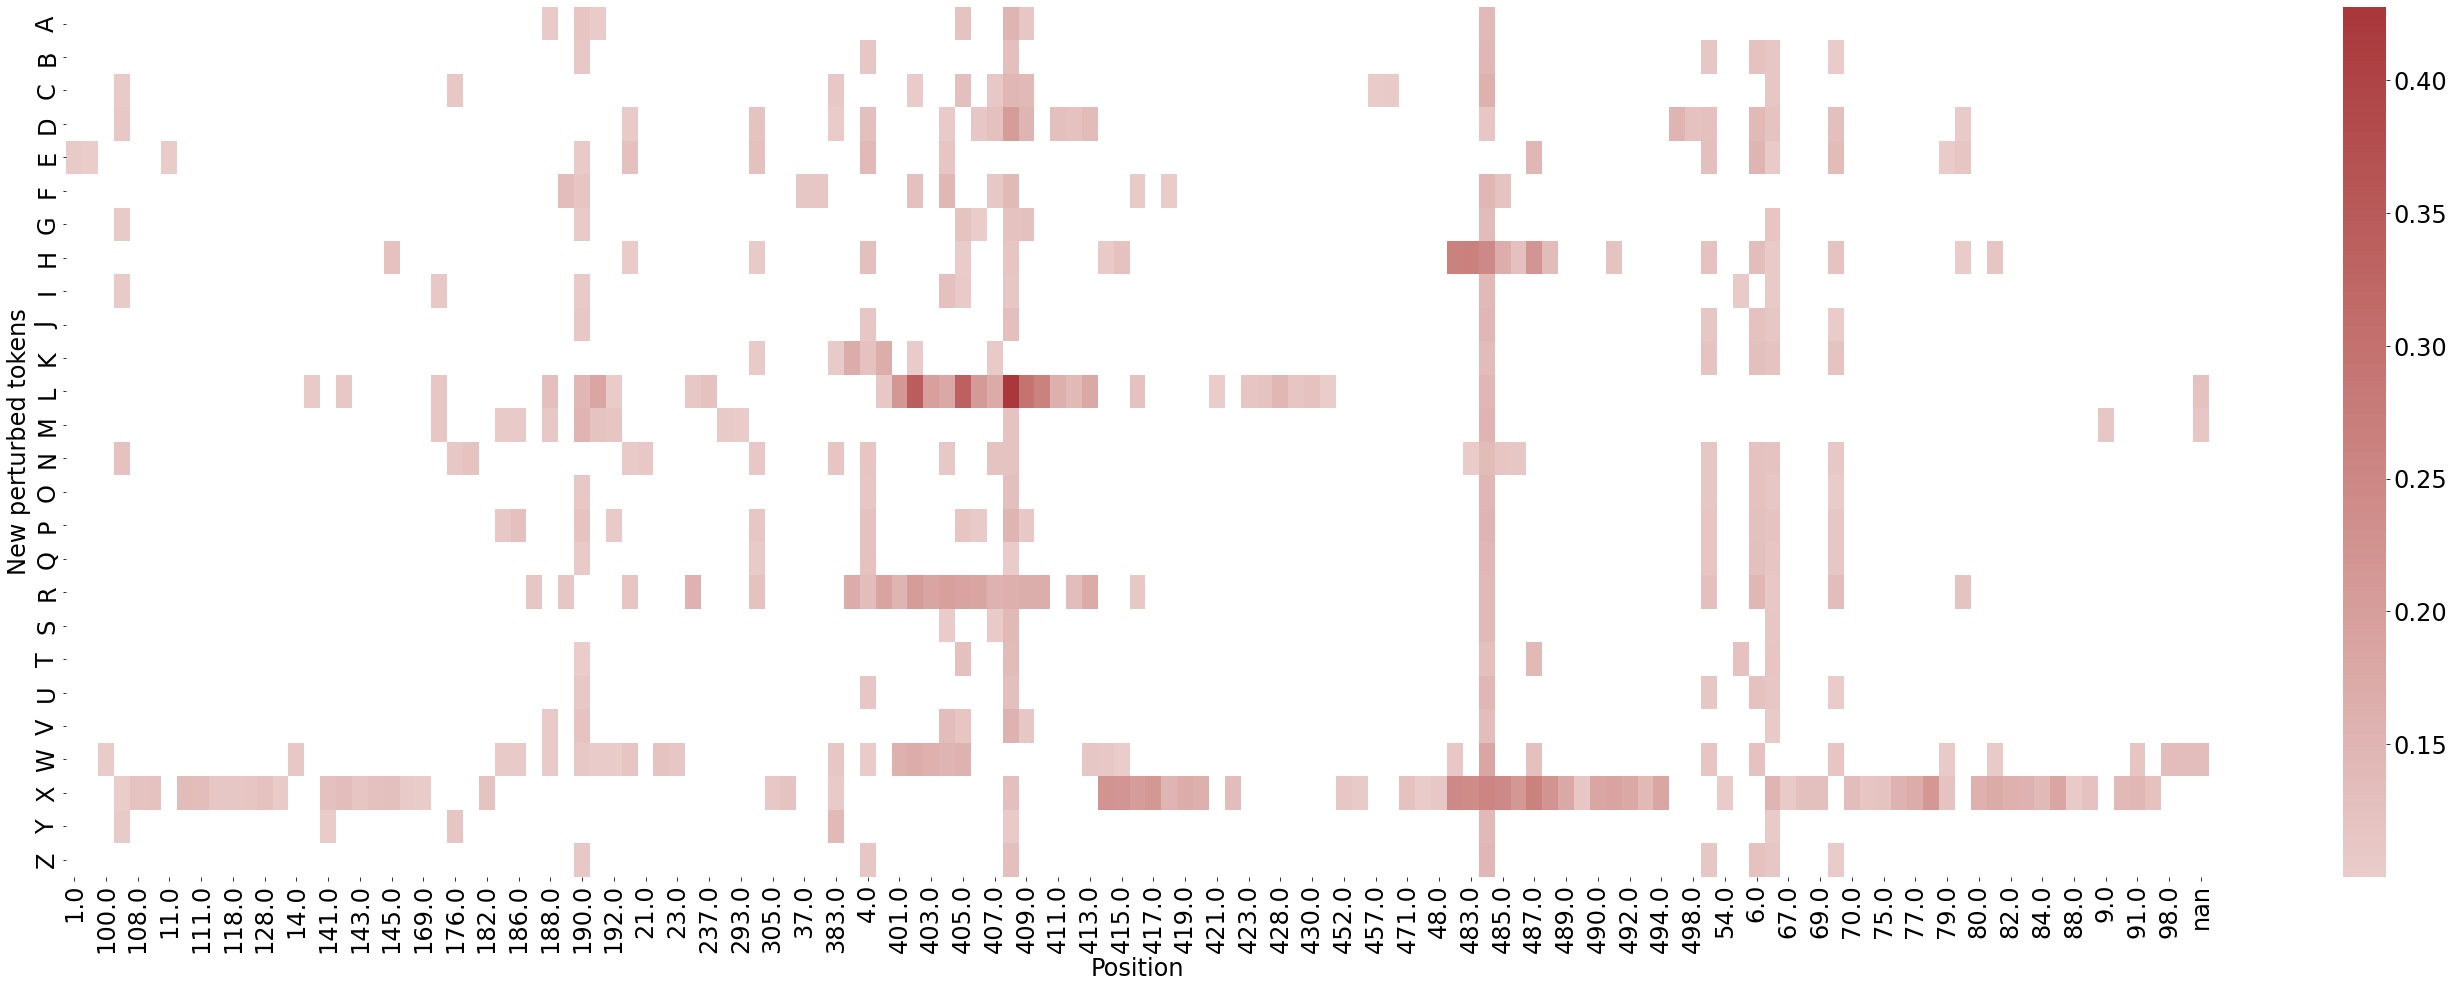

In [22]:
plt.clf()
plt.figure(figsize=(48, 16))
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
# plt.rcParams['figure.autolayout'] = True
ax = sns.heatmap(df, cmap=cmap, center=0)
plt.xlabel('Position', fontsize=24)
plt.ylabel('New perturbed tokens', fontsize=24)
plt.show()

In [23]:
df.mean(axis=0)

perturb_seq_pos
1.0      0.105144
10.0     0.100002
100.0    0.103122
104.0    0.107672
108.0    0.119780
           ...   
91.0     0.130403
92.0     0.122592
98.0     0.133551
99.0     0.131188
nan      0.122423
Length: 135, dtype: float64

<Figure size 432x288 with 0 Axes>

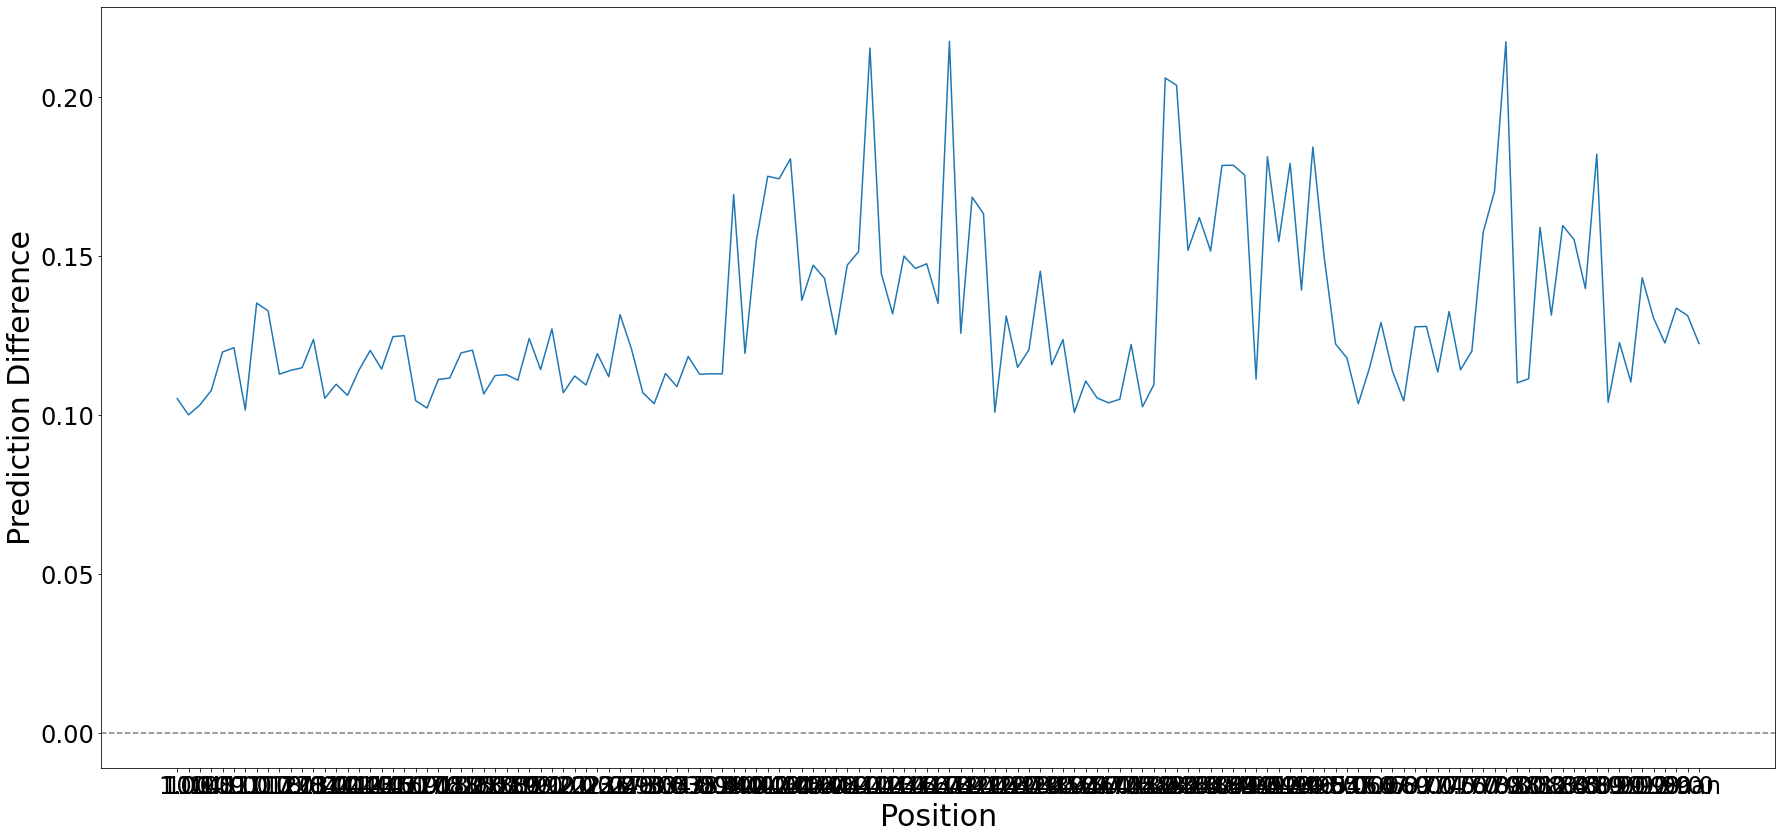

In [24]:
plt.clf()
plt.figure(figsize=(30, 14))
ax = sns.lineplot(df.mean(axis=0))
ax.axhline(0.0, color="gray", linestyle="--")
plt.rcParams['xtick.labelsize'] = 30
plt.rcParams['ytick.labelsize'] = 30
plt.xlabel('Position', fontsize=30)
plt.ylabel('Prediction Difference', fontsize=30)
#ax.set_xlim(0, 1273)
plt.show()